In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import sklearn
import string
import nltk
import re

In [5]:
text_df = pd.read_csv("../data/data_full.csv")
text_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [6]:
text_df = text_df[["text"]]
text_df["text"] = text_df["text"].astype(str)

In [7]:
text_df.dropna(inplace=True)
text_df.isna().sum()

text    0
dtype: int64

In [8]:
text_df.head(10)

,text
547202,@266138 Thanks! We're glad you get to sit toge...
691124,@ComcastCares: #mobile_Care\nI've been on hold...
726990,"@313602 Hey, sorry to hear. Does the latest tr..."
1050759,@393586 @GWRHelp I can't see the full details ...
132673,@153309 are having along with your Gamertag? P...
486031,@BofA_Help It's been 69 mins. How can u ppl pl...
753756,@320259 Thanks for those details. We’d love to...
1466497,.@Delta from DTW to ATL for a couple hours the...
1070951,You made it come to this @115714... https://t....
1805259,"@581482 However, if that workaround does not w..."


In [9]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196824 entries, 547202 to 2434863
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    196824 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [10]:
text_df["text"] = text_df["text"].str.lower().str.strip()
text_df.head()

,text
547202,@266138 thanks! we're glad you get to sit toge...
691124,@comcastcares: #mobile_care\ni've been on hold...
726990,"@313602 hey, sorry to hear. does the latest tr..."
1050759,@393586 @gwrhelp i can't see the full details ...
132673,@153309 are having along with your gamertag? p...


In [11]:
AUTHOR_PATTERN = re.compile(r"^@\S+ ")

def remove_author(text):
    return re.sub(AUTHOR_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_author)
text_df.head()

,text
547202,thanks! we're glad you get to sit together.
691124,#mobile_care\ni've been on hold for 47 minutes...
726990,"hey, sorry to hear. does the latest tracking c..."
1050759,@gwrhelp i can't see the full details of your ...
132673,are having along with your gamertag? please in...


In [12]:
HTTP_PATTERN = re.compile(r"https?://\S+|www\.\S+ ")

def remove_http(text):
    return re.sub(HTTP_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_http).str.strip()
text_df.head()

,text
547202,thanks! we're glad you get to sit together.
691124,#mobile_care\ni've been on hold for 47 minutes...
726990,"hey, sorry to hear. does the latest tracking c..."
1050759,@gwrhelp i can't see the full details of your ...
132673,are having along with your gamertag? please in...


In [13]:
HTML_PATTERN = re.compile('<.*?>')

def remove_html(text):
    return re.sub(HTML_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_html)
text_df.head()

,text
547202,thanks! we're glad you get to sit together.
691124,#mobile_care\ni've been on hold for 47 minutes...
726990,"hey, sorry to hear. does the latest tracking c..."
1050759,@gwrhelp i can't see the full details of your ...
132673,are having along with your gamertag? please in...


In [14]:
text_df["text"] = text_df["text"].str.replace("\n", " ")
text_df.head()

,text
547202,thanks! we're glad you get to sit together.
691124,#mobile_care i've been on hold for 47 minutes ...
726990,"hey, sorry to hear. does the latest tracking c..."
1050759,@gwrhelp i can't see the full details of your ...
132673,are having along with your gamertag? please in...


In [15]:
text_df["text"] = text_df["text"].str.replace("’", "'")
APOSTROPHES = {
    "'m":    "am",
    "'re":   "are",
    "'ve":   "have",
    "'ll":   "will",
    "'d":    "would",
    "won't": "will not",
    "can't": "cannot",
    "n't":   "not",
}

def convert_apostrophes(text):
    for apostrophe, value in APOSTROPHES.items():
        text = re.sub(u'('+apostrophe+')', f' {value} ', text)
    return text

text_df["text"] = text_df["text"].apply(convert_apostrophes)
text_df.head()

,text
547202,thanks! we are glad you get to sit together.
691124,#mobile_care i have been on hold for 47 minut...
726990,"hey, sorry to hear. does the latest tracking c..."
1050759,@gwrhelp i cannot see the full details of yo...
132673,are having along with your gamertag? please in...


In [16]:
ABBREVIATIONS = {}

with open("../data/abbr.txt", 'r') as f:
    for line in f.readlines():
        line = line.lower().strip().replace(",", "")
        k, v = line.split("=")
        ABBREVIATIONS.update({k: v})

def convert_abbreviations(text):
    return " ".join([
        ABBREVIATIONS[w] if w in ABBREVIATIONS else w
        for w in text.split()
    ])

text_df["text"] = text_df["text"].apply(convert_abbreviations)
text_df.head()

,text
547202,thanks! we are glad you get to sit together.
691124,#mobile_care i have been on hold for 47 minute...
726990,"hey, sorry to hear. does the latest tracking c..."
1050759,@gwrhelp i cannot see the full details of your...
132673,are having along with your gamertag? please in...


In [17]:
NUMBER_PATTERN = re.compile(r"\d*")

def remove_numbers(text):
    return re.sub(NUMBER_PATTERN, "", text)

text_df["text"] = text_df["text"].apply(remove_numbers)
text_df.head()

,text
547202,thanks! we are glad you get to sit together.
691124,#mobile_care i have been on hold for minutes ...
726990,"hey, sorry to hear. does the latest tracking c..."
1050759,@gwrhelp i cannot see the full details of your...
132673,are having along with your gamertag? please in...


In [18]:
PUNCTUATION_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))

text_df["text"] = text_df["text"].apply(remove_punctuation)
text_df.head()

,text
547202,thanks we are glad you get to sit together
691124,mobilecare i have been on hold for minutes be...
726990,hey sorry to hear does the latest tracking con...
1050759,gwrhelp i cannot see the full details of your ...
132673,are having along with your gamertag please inc...


In [19]:
EMOT_EMOJI = {
    emoji: value.replace(":", "").replace(",", "").replace(" ", "_").lower()
    for emoji, value in {**EMOTICONS_EMO, **UNICODE_EMOJI}.items()
}

def convert_emot_emoji(text):
    for emoji, value in EMOT_EMOJI.items():
        text = re.sub(u'('+re.escape(emoji)+')', f" {value}", text)
    return text

text_df["text"] = text_df["text"].apply(convert_emot_emoji)
text_df.head()

,text
547202,thanks we are glad you get to sit together
691124,mobilecare i have been on hold for minutes be...
726990,hey sorry to hear does the latest tracking con...
1050759,gwrhelp i cannot see the full details of your ...
132673,are having along with your gamertag please inc...


In [20]:
ENG_PATTERN = re.compile(r"^[a-z_ ]*$")

def extract_eng(text):
    if not re.match(ENG_PATTERN, text):
        print(text)
    return not re.match(ENG_PATTERN, text)

text_df["text"].copy().apply(extract_eng).sum()

 there is but they are expensive as fuck £ vs £ hmmm
its official our finest mince pies won st place in s taste test 1st_place_medal get them instore and online
確認しました。このボタンを押すと無料会員になりますという表示はされないということでしょうか？
las donaciones son voluntarias las donaciones son exclusivamente atraves de tarjeta de crédito ls
guten tag bitte entschuldigen sie uns vielmals dass sie diese erfahrung machen müssten das ist definitiv nicht was wir wollen
oui mais je comprend pas pourquoi vous effectuez pas le paiement au moment de lopération et que vous remboursez si problème tout simplement
hi my phones on silent but still makes a noise when the cameras on do you know what might be the problem person_shrugging medium-light_skin_tone‍ female_sign️
 नवम्बर की शाम बजे बेतियाहाता गोरखपुर में आइडिया शॉपरामजश राय जी के कपड़े के दुकान के बगल में पर अपना रिलायंस नम्बर आइडिया में पोर्ट कराने गया था ।वहाँ आधार से लिंक करा कर मुझे एक सिम मिला और मुझसे frc के नाम पर  रुपये धर्मेंद्र  ने लिए।मुझे frc नही
 chocolate_bar amp 

12713

In [21]:
STOPWORDS = stopwords.words("english")

def remove_stopwords(text):
    return " ".join(w for w in nltk.word_tokenize(text) if not w in STOPWORDS)

text_df["text"] = text_df["text"].apply(remove_stopwords)
text_df.head()

,text
547202,thanks glad get sit together
691124,mobilecare hold minutes demand working please ...
726990,hey sorry hear latest tracking confirm order d...
1050759,gwrhelp see full details ticket flexible fares...
132673,along gamertag please include verbatims error ...


In [22]:
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for w in text.split():
        if w in misspelled_words:
            corrected_text.append(spell.correction(w))
        else:
            corrected_text.append(w)
    return " ".join(corrected_text)

text_df["text"] = text_df["text"].apply(correct_spellings)
text_df.head()

,text
547202,thanks glad get sit together
691124,mobilecare hold minutes demand working please ...
726990,hey sorry hear latest tracking confirm order d...
1050759,whelp see full details ticket flexible fares w...
132673,along nametag please include verbatim error se...


In [23]:
# Для текущего датасета предпочтительно использовать лемматизацию в виду
# большого количества сложных слов, которые требуют более тщательной обработки,
# что отражается на скорости обработки данных
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])

text_df["text"] = text_df["text"].apply(lemmatize_words)
text_df.head()

,text
547202,thanks glad get sit together
691124,mobilecare hold minute demand working please h...
726990,hey sorry hear latest tracking confirm order d...
1050759,whelp see full detail ticket flexible fare wou...
132673,along nametag please include verbatim error se...


In [24]:
# Часто встречающиеся слова в датасете
cnt = Counter()
for text in text_df["text"].values:
    for word in text.split():
        cnt[word] += 1

most_common = cnt.most_common(10)
most_common

[('u', 31899),
 ('please', 28249),
 ('do', 24916),
 ('help', 20185),
 ('hi', 15859),
 ('would', 15547),
 ('i', 15244),
 ('get', 14664),
 ('thanks', 14617),
 ('sorry', 13482)]

In [25]:
FREQWORDS = set([w for (w, wc) in most_common])

def remove_freqwords(text):
    return " ".join([w for w in str(text).split() if w not in FREQWORDS])

text_df["text"] = text_df["text"].apply(remove_freqwords)
text_df.head()

,text
547202,glad sit together
691124,mobilecare hold minute demand working like credit
726990,hey hear latest tracking confirm order due del...
1050759,whelp see full detail ticket flexible fare cos...
132673,along nametag include verbatim error seeing is


In [26]:
# Редко встречающиеся слова в датасете
num_rare_words = 20
less_common = cnt.most_common()[:-num_rare_words-1:-1]
less_common

[('isguacextra', 1),
 ('chipotletweetsthis', 1),
 ('negan', 1),
 ('embutida', 1),
 ('iluminação', 1),
 ('sebastien', 1),
 ('jacobi', 1),
 ('awkwardly', 1),
 ('evasion', 1),
 ('reasonsthis', 1),
 ('ifferent', 1),
 ('westburyalways', 1),
 ('overture', 1),
 ('toussaint', 1),
 ('highschool', 1),
 ('visaestaeta', 1),
 ('hamuezi', 1),
 ('ご不便をおかけしております。当サイトでも状況を確認した上で対応させていただきますので、恐れ入りますが、以下のリンクよりカスタマーサービスにお問い合わせください。',
  1),
 ('erhälst', 1),
 ('リプライありがとうございました', 1)]

In [27]:
RAREWORDS = set([w for (w, wc) in less_common])

def remove_rarewords(text):
    return " ".join([w for w in str(text).split() if w not in RAREWORDS])

text_df["text"] = text_df["text"].apply(remove_rarewords)
text_df.head()

,text
547202,glad sit together
691124,mobilecare hold minute demand working like credit
726990,hey hear latest tracking confirm order due del...
1050759,whelp see full detail ticket flexible fare cos...
132673,along nametag include verbatim error seeing is


In [28]:
# Разделение на тестовую и обучающую выборки
train_data, test_data = train_test_split(text_df["text"], train_size=0.8)

In [29]:
# Векторизация текста на основе частоты каждого слова
count_vect = CountVectorizer(analyzer='word', max_features=500, min_df=5, max_df=0.8)
count_terms= count_vect.fit_transform(train_data)
count_tokens = count_vect.get_feature_names_out()
count_terms_vect = count_vect.transform(test_data)

df_count_vect = pd.DataFrame(data=count_terms_vect.todense(), columns=count_tokens)
df_count_vect

,able,access,account,act,actually,ad,add,additional,address,advise,...,working,worry,worst,wrong,xbox,yall,year,yes,yesterday,yet
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
39363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_count_vect_sum = df_count_vect.sum()
print(f'Наиболее часто встречающееся слово в датасете: {df_count_vect_sum.idxmax()} - {df_count_vect_sum.max()}')

Наиболее часто встречающееся слово в датасете: service - 2267


In [31]:
df_count_vect.describe()

,able,access,account,act,actually,ad,add,additional,address,advise,...,working,worry,worst,wrong,xbox,yall,year,yes,yesterday,yet
count,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,...,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000,39365.000000
mean,0.019713,0.006960,0.048139,0.003963,0.004420,0.003607,0.005589,0.003582,0.034548,0.004166,...,0.018062,0.002871,0.004903,0.006935,0.005894,0.006503,0.010365,0.012727,0.004700,0.010136
std,0.140829,0.085252,0.231070,0.068994,0.067853,0.061624,0.076567,0.059742,0.192258,0.065971,...,0.138415,0.053501,0.070932,0.085700,0.087971,0.084690,0.105215,0.112548,0.069132,0.101927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,3.000000,2.000000,...,6.000000,1.000000,2.000000,3.000000,4.000000,2.000000,3.000000,2.000000,2.000000,2.000000


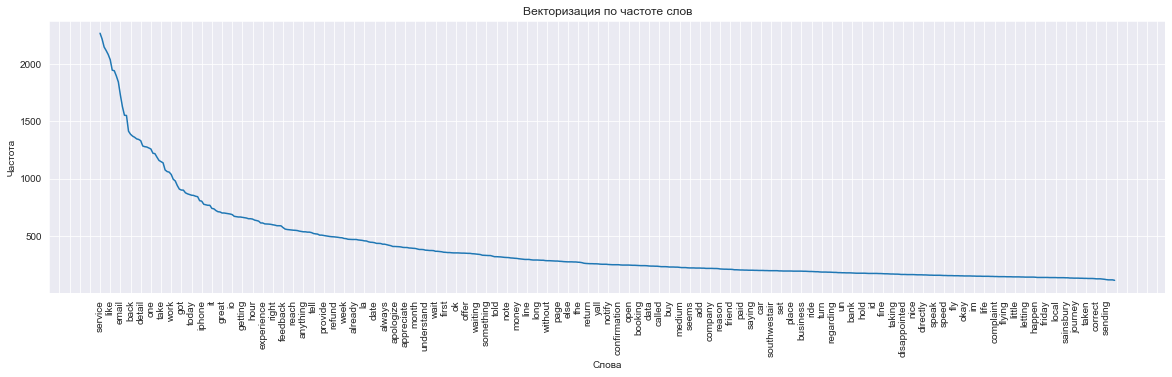

In [32]:
_, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_xlabel('Слова')
ax.set_ylabel('Частота')
ax.set_title("Векторизация по частоте слов")
ax.xaxis.set_major_locator(ticker.MultipleLocator(df_count_vect.shape[1] / 100))
plt.xticks(rotation = 90)

plt.plot(df_count_vect_sum.sort_values(ascending=False))
plt.show()

In [33]:
# Метод главных компонентов (сжатая корреляция)
pca = PCA(n_components=100)
corr_pca = pca.fit_transform(df_count_vect)
corr_pca

array([[-3.69625956e-02,  9.63031461e-01, -2.29806911e-01, ...,
         1.05258787e-02,  8.30977925e-02,  1.14954963e-01],
       [-3.62384531e-03, -6.80869074e-02, -2.17801888e-02, ...,
         4.43557940e-02, -7.18116404e-02,  3.47523550e-02],
       [-2.03899987e-02,  3.25112986e-01, -2.35328312e-01, ...,
        -3.97167471e-01,  1.43423853e-01, -8.09609636e-03],
       ...,
       [ 4.88647450e-04, -2.33785847e-01, -9.67644721e-02, ...,
         5.86994753e-02, -2.26040408e-01, -1.87689846e-01],
       [-1.55384000e-02,  2.47309988e-01, -1.53377236e-01, ...,
        -1.18506243e-01, -1.23566314e-01, -2.34056990e-01],
       [-3.59807553e-03, -9.39537387e-02, -1.07375399e-02, ...,
         3.14962456e-03,  3.14304549e-02, -1.65681691e-02]])

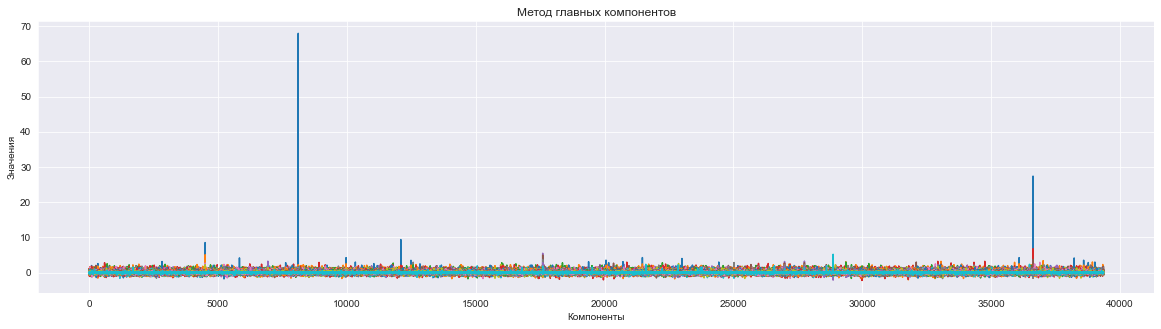

In [34]:
_, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_xlabel('Компоненты')
ax.set_ylabel('Значения')
ax.set_title("Метод главных компонентов")

plt.plot(corr_pca)
plt.show()